# 中央値の信頼区間2

Part 1: [中央値の信頼区間](https://github.com/genkuroki/public/blob/main/0028/confidence%20interval%20of%20median.ipynb)
$
\newcommand\R{\Bbb{R}}
\newcommand\Beta{\operatorname{Beta}}
\newcommand\Binomial{\operatorname{Binomial}}
\newcommand\dist{\operatorname{dist}}
\newcommand\empirical{\operatorname{empirical}}
\newcommand\pval{\operatorname{pval}}
\newcommand\median{\operatorname{median}}
\newcommand\ci{\operatorname{ci}}
\newcommand\pdf{\operatorname{pdf}}
\newcommand\cdf{\operatorname{cdf}}
\newcommand\ecdf{\operatorname{ecdf}}
\newcommand\quantile{\operatorname{quantile}}
\newcommand\on{\operatorname}
$

In [1]:
using Distributions
using StatsPlots
default(titlefontsize=10, fmt=:png)
using Random
using StatsBase
using QuadGK
using StaticArrays

name(dist::UnivariateDistribution) = replace(string(dist), r"{[^{.]*}"=>"")

function pdf_median_true(n, z)
    0 < z < 1 || return 0.0
    m = n / 2
    p(x, y) = pdf(Dirichlet(SVector(m, 1, m)), SVector(x, y-x, 1-y))
    2quadgk(x -> p(x, 2z - x), 0, z)[1]
end

function plot_mediandists(n; kwargs...)
    plot(x -> pdf_median_true(n, x), 0, 1; label="true dist")
    plot!(x -> pdf(Beta((n+1)/2, (n+1)/2), x), 0, 1; ls=:dash, label="n")
    plot!(x -> pdf(Beta((n+2)/2, (n+2)/2), x), 0, 1; ls=:dashdot, label="n'=n+1")
    title!("dist of median and approx: n = $n")
    plot!(; kwargs...)
end

function plot_mediandist_approx()
    PP = []
    P = plot_mediandists(2; legend=:bottom)
    push!(PP, P)
    for n in 4:2:12
    P = plot_mediandists(n; legend=false)
        push!(PP, P)
    end
    plot(PP...; size=(900, 540), layout=(2, 3))
end

plot_mediandist_approx (generic function with 1 method)

## ブートストラップ法

$n$ が奇数のとき, 一様分布 $\on{Uniform}(0, 1)$ のサイズ $n$ の標本の中央値の真の分布は $\Beta((n+1)/2, (n+1)/2)$ になる([順序統計量 - Wikipedia](https://ja.wikipedia.org/wiki/%E9%A0%86%E5%BA%8F%E7%B5%B1%E8%A8%88%E9%87%8F) を参照せよ).

$n$ が10以上の偶数の場合には, 一様分布 $\on{Uniform}(0, 1)$ のサイズ $n$ の標本の中央値の真の分布の良い近似として, $n' = n+1$ とおいて, $\Beta((n'+1)/2, (n'+1)/2)$ を採用できる. 以下のセルを見よ.

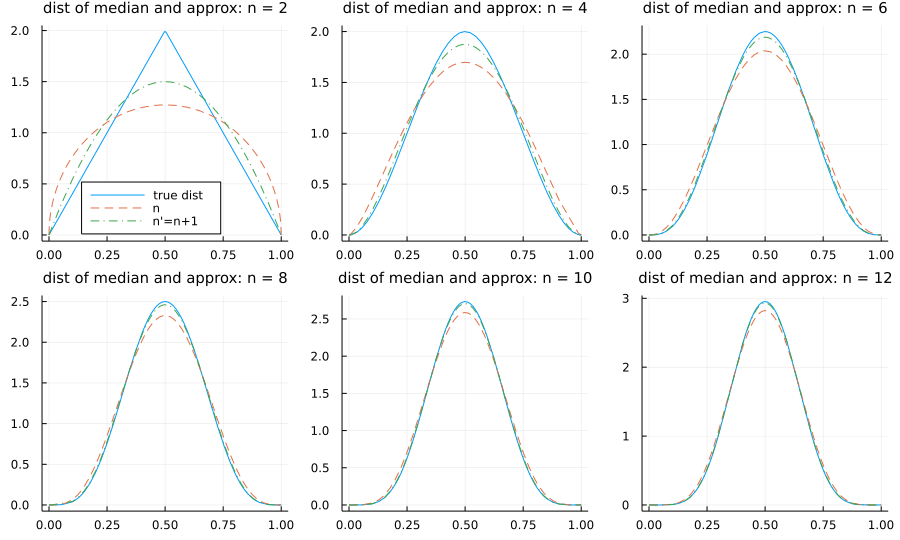

In [2]:
plot_mediandist_approx()

$n$ が偶数の場合にはさらにもとの標本 $X=(X_1,\ldots,X_n)$ を小さな順に

$$
X(1) \le X(2) \le \cdots \le X(n)
$$

と並べ直して, 

$$
X' = \left(X(1), \frac{X(1)+X(2)}{2}, \frac{X(2)+X(3)}{2}, \ldots, \frac{X(n-1)+X(n)}{2}, X(n)\right)
$$

に置き換えた方が精度が上がると考えられる. $X'$ の中には $X$ の中央値 $(X(n/2)+X(n/2+1))/2$ が含まれることに注意せよ. 両端も調節した方がよいかもしれないが, 調節によって母集団分布に含まれない値が追加される危険性を考慮し, 両端を調節しないことにした.

$n$ が奇数のときは $n'=n$ とおき, $n$ が偶数のときには $n'=n+1$ とおいて, 標本サイズ $n$ に対して, 

$$
\on{beta}=\Beta((n'+1)/2, (n'+1)/2)
$$

と定め(左右対称なベータ分布), $n$ が奇数のときには $X'=X$ とおき, $n$ が偶数のときには上のように $X'$ を定める.

このとき, 信頼係数 $1-\alpha$ の中央値の信頼区間 $[L, U]$ を次のように構成できる(ブートストラップ法):

$$
\begin{aligned}
&
L = \quantile(X', \quantile(\on{beta}, \alpha/2)),
\\ &
U = \quantile(X', \quantile(\on{beta}, 1-\alpha/2)).
\end{aligned}
$$

対応するP値函数は次のように書ける:

$$
\pval_{\on{bootstrap}}(X', a) = \min\left(
\begin{array}{l}
1 \\
2\cdf(\on{beta}, \ecdf(X')(a)) \\
2(1 - \cdf(\on{beta}, \ecdf(X')(a))) \\
\end{array}
\right).
$$

信頼区間とP値の概念は表裏一体である(竹内啓『数理統計学』 p.103, 竹村彰通『現代数理統計学』 p.202, 久保川達也『現代数理統計学の基礎』 p.169).
P値函数と信頼区間の対応は, 与えられたデータについて, P値函数の値がα以上になるパラメータの範囲が信頼区間に一致するという条件で与えられる.

データが与えられたとき, 横軸をパラメータとするP値函数のグラフを描いたとき, 
そのグラフを高さ $\alpha$ で切断して得られる区間が信頼係数 $1-\alpha$ の信頼区間になる.

異なる方法で構成された信頼区間を比較するには, 対応するP値函数を比較すればよい.

In [3]:
function beta_median(n)
    n += iseven(n)
    Beta((n+1)/2, (n+1)/2)
end

function sample_beta_median!(X)
    isodd(length(X)) && return X
    sort!(X)
    [X[1]; (@view(X[1:end-1]) .+ @view(X[2:end])) ./ 2; X[end]] 
end

function ci_median_bootstrap_old(X::AbstractVector; α = 0.05)
    beta = beta_median(length(X))
    L = quantile(X, quantile(beta, α/2))
    U = quantile(X, quantile(beta, 1 - α/2))
    L, U
end

function ci_median_bootstrap(X::AbstractVector; α = 0.05)
    beta = beta_median(length(X))
    X = sample_beta_median!(X)
    L = quantile(X, quantile(beta, α/2))
    U = quantile(X, quantile(beta, 1 - α/2))
    L, U
end

function cdf_median_bootstrap_old(X::AbstractVector, a)
    beta = beta_median(length(X))
    cdf(beta, ecdf(X)(a))
end

function cdf_median_bootstrap(X::AbstractVector, a)
    beta = beta_median(length(X))
    X = sample_beta_median!(X)
    cdf(beta, ecdf(X)(a))
end

function pval_median_bootstrap(X, a)
    c = cdf_median_bootstrap(X, a)
    min(1, 2c, 2(1 - c))
end

pval_median_bootstrap (generic function with 1 method)

In [4]:
quantile(0:10, 0.25), quantile(0:10, 0.75)

(2.5, 7.5)

In [5]:
@show sample_beta_median!([8, 7, 6, 5, 4, 3, 2, 1]);

sample_beta_median!([8, 7, 6, 5, 4, 3, 2, 1]) = [1.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.0]


[L, U] = [4.3604703774527716, 7.1714739480618155]


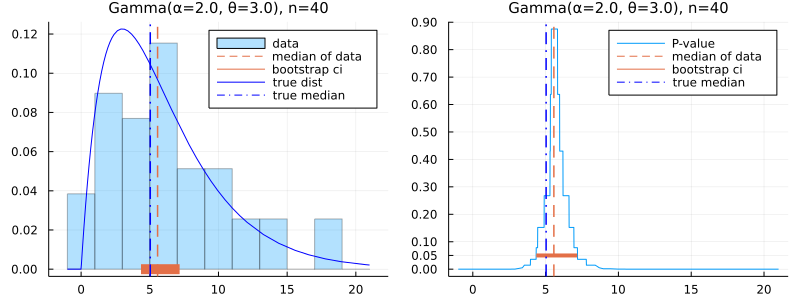

In [6]:
Random.seed!(3734649)

# テストサンプルの生成
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)

# 信頼区間の計算
L, U = ci_median_bootstrap(X; α = 0.05)
@show [L, U]

# プロット
Q1 = histogram(X; norm=true, alpha=0.3, bin=-1:2:21, label="data")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!([L, U], zeros(2); label="bootstrap ci", lw=10, c=2)
plot!(dist, -1, 21; label="true dist", c=:blue)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")

Q2 = plot(x -> pval_median_bootstrap(X, x), -1, 21; label="P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!([L, U], fill(0.05, 2); label="bootstrap ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(Q1, Q2; size=(800, 300))

## 二項分布に帰着

標本 $X=(X_1,\ldots,X_n)$ を小さな順に並べたもの(sortしたもの)を $X(1)\le\cdots\le X(n)$ と書く.

$a$ が連続的母集団分布の中央値(真の中央値)ならばその母集団分布のサイズ $n$ の標本 $X=(X_1,\ldots,X_n)$ の中での $a$ 以下の値の個数が $k$ になる確率は二項分布 $\Binomial(n, 1/2)$ で $k$ が生じる確率になる. このことを使っても中央値の信頼区間やP値を構成することができる.

以下では $n$ が偶数のとき $n'=n$ とおき, $n$ が奇数のとき $n'=n+1$ とおく. さらに, $n$ が偶数のとき $X' = (X(1),\ldots,X(n)))$ とおき, $n$ が奇数のとき $X'$ を

$$
X' = \left(X(1), \frac{X(1)+X(2)}{2}, \frac{X(2)+X(3)}{2}, \ldots, \frac{X(n-1)+X(n)}{2}, X(n)\right)
$$

と定め, $X'$ の第 $i$ 成分を $X'(i)$ と書く. $X'$ の成分の個数は $n'$ になる.

$\on{bin} = \Binomial(n', 1/2)$ (試行回数 $n'$ の二項分布)とおく.

このとき, 信頼係数 $1-\alpha$ の中央値の信頼区間 $[L, U]$ を次のようにも構成できる:

$$
\begin{aligned}
&
L = X'(\quantile(\on{bin}, \alpha/2)),
\\ &
U = X'(\quantile(\on{bin}, 1 - \alpha/2)).
\end{aligned}
$$

対応するP値函数は次のように書ける:

$$
\pval_{\on{binomial}}(X, a) = \min\left(
\begin{array}{l}
1 \\
2\cdf(\on{bin}, k) \\
2(1 - (\cdf(\on{bin}, k)) \\
\end{array}
\right).
$$

ここで $k$ は $a$ 以下の $X'(i)$ の個数である.

信頼区間とP値の概念は表裏一体である(竹内啓『数理統計学』 p.103, 竹村彰通『現代数理統計学』 p.202, 久保川達也『現代数理統計学の基礎』 p.169).
P値函数と信頼区間の対応は, 与えられたデータについて, P値函数の値がα以上になるパラメータの範囲が信頼区間に一致するという条件で与えられる.

データが与えられたとき, 横軸をパラメータとするP値函数のグラフを描いたとき, 
そのグラフを高さ $\alpha$ で切断して得られる区間が信頼係数 $1-\alpha$ の信頼区間になる.

異なる方法で構成された信頼区間を比較するには, 対応するP値函数を比較すればよい.

In [7]:
bin_median_old(n) = Binomial(n, 1/2)

function bin_median(n)
    n += isodd(n)
    Binomial(n, 1/2)
end

function sample_bin_median!(X)
    iseven(length(X)) && return sort!(X)
    sort!(X)
    [X[1]; (@view(X[1:end-1]) .+ @view(X[2:end])) ./ 2; X[end]] 
end

function ci_median_binomial_old(X::AbstractVector; α = 0.05)
    bin = bin_median_old(length(X))
    X′ = sort(X)
    L = X′[quantile(bin, α/2)]
    U = X′[quantile(bin, 1 - α/2)+1]
    L, U
end

function ci_median_binomial(X::AbstractVector; α = 0.05)
    bin = bin_median(length(X))
    X′ = sample_bin_median!(X)
    L = X′[quantile(bin, α/2)]
    U = X′[quantile(bin, 1 - α/2)+1]
    L, U
end

function pval_median_binomial_old(X::AbstractVector, a)
    bin = bin_median(length(X))
    k  = count(≤(a), X)
    c = cdf(bin, k)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function pval_median_binomial(X::AbstractVector, a)
    bin = bin_median(length(X))
    X′ = sample_bin_median!(X)
    k  = count(≤(a), X′)
    c = cdf(bin, k)
    min(1, 2c, 2(1 - c))
end

pval_median_binomial (generic function with 1 method)

ci_bst = ci_median_bootstrap(X; α = 0.05) = (4.3604703774527716, 7.1714739480618155)
ci_bin = ci_median_binomial(X; α = 0.05) = (4.31001037009797, 7.305395464252875)


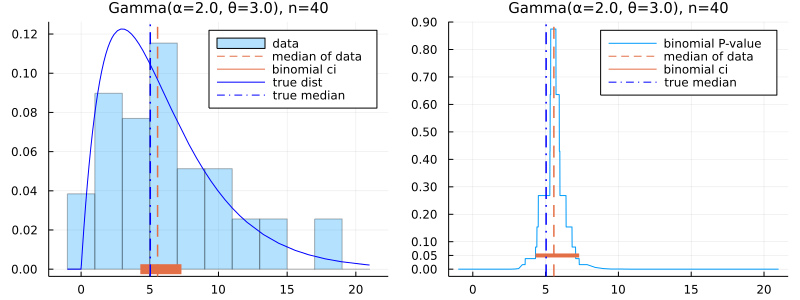

In [8]:
Random.seed!(3734649)

# テストサンプルの生成
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)

# 信頼区間の計算
@show ci_bst = ci_median_bootstrap(X; α = 0.05)
@show ci_bin = ci_median_binomial(X; α = 0.05)

# プロット
Q3 = histogram(X; norm=true, alpha=0.3, bin=-1:2:21, label="data")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), zeros(2); label="binomial ci", lw=10, c=2)
plot!(dist, -1, 21; label="true dist", c=:blue)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")

Q4 = plot(x -> pval_median_binomial(X, x), -1, 21; label="binomial P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), fill(0.05, 2); label="binomial ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(Q3, Q4; size=(800, 300))

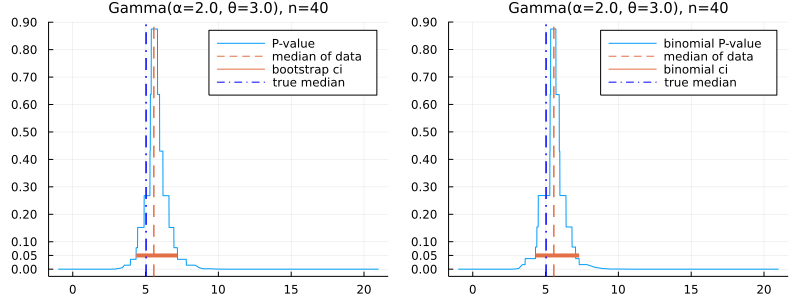

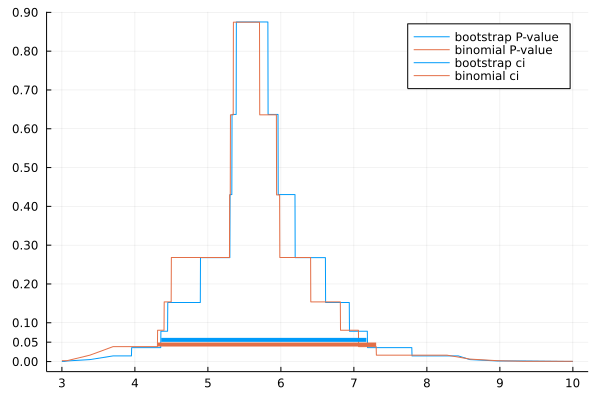

In [9]:
plot(Q2, Q4; size=(800, 300)) |> display

plot(x -> pval_median_bootstrap(X, x), 3, 10; label="bootstrap P-value")
plot!(x -> pval_median_binomial(X, x), 3, 10; label="binomial P-value")
plot!(collect(ci_bst), fill(0.056, 2); label="bootstrap ci", lw=4, c=1)
plot!(collect(ci_bin), fill(0.044, 2); label="binomial ci", lw=4, c=2)
plot!(; xtick=-1:21, ytick=[0:0.05:0.1; 0.2:0.1:1])

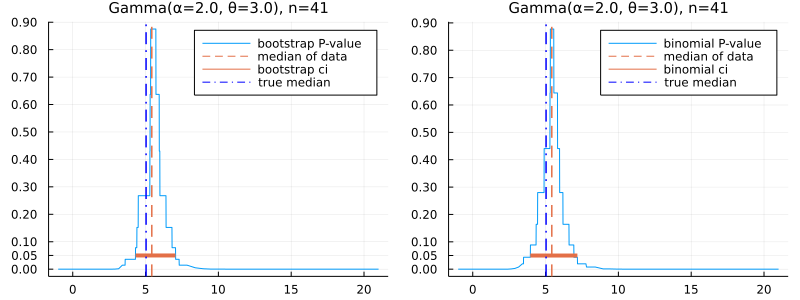

ci_bst = ci_median_bootstrap(X; α = 0.05) = (4.3148853153789455, 7.050518310337038)
ci_bin = ci_median_binomial(X; α = 0.05) = (3.9555461851725164, 7.184660789580056)


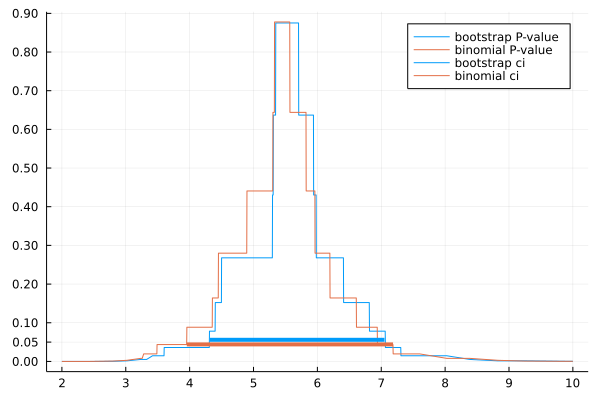

In [10]:
Random.seed!(3734649)

# テストサンプルの生成
dist = Gamma(2, 3)
n = 41
X = rand(dist, n)

# 信頼区間の計算
@show ci_bst = ci_median_bootstrap(X; α = 0.05)
@show ci_bin = ci_median_binomial(X; α = 0.05)

# プロット
R2 = plot(x -> pval_median_bootstrap(X, x), -1, 21; label="bootstrap P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bst), fill(0.05, 2); label="bootstrap ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

R4 = plot(x -> pval_median_binomial(X, x), -1, 21; label="binomial P-value")
vline!([median(X)]; label="median of data", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), fill(0.05, 2); label="binomial ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(R2, R4; size=(800, 300)) |> display

plot(x -> pval_median_bootstrap(X, x), 2, 10; label="bootstrap P-value")
plot!(x -> pval_median_binomial(X, x), 2, 10; label="binomial P-value")
plot!(collect(ci_bst), fill(0.056, 2); label="bootstrap ci", lw=4, c=1)
plot!(collect(ci_bin), fill(0.044, 2); label="binomial ci", lw=4, c=2)
plot!(; xtick=-1:21, ytick=[0:0.05:0.1; 0.2:0.1:1])

## 二項分布とベータ分布の関係

二項分布 $\Beta(n, p)$ における累積分布函数はベータ分布の累積分布函数で記述できる:

$$
\begin{aligned}
&
\sum_{j=0}^k \binom{n}{j} p^j(1-p)^{n-j} = \int_p^1 \frac{t^k(1-k)^{n-k-1}}{B(k+1, n-k)}\,dt,
\\ &
\sum_{j=k}^n \binom{n}{j} p^j(1-p)^{n-j} = \int_0^p \frac{t^{k-1}(1-k)^{n-k}}{B(k, n-k+1)}\,dt.
\end{aligned}
$$

以下のセルに数値的な確認がある. 証明は両辺を $p$ で微分しても得られるし, 右辺の積分で部分積分を繰り返しても得られる. もしくはより確率論的に, 一様分布 $\on{Uniform}(0,1)$ のサイズ $n$ の標本中の $p$ 以下の数値の個数が $k$ 以上になる確率を2通りに記述することによって, 後者の公式の直観的な説明を得ることもできる. 右辺のベータ分布における確率は, 一様分布 $\on{Uniform}(0,1)$ のサイズ $n$ の標本中の下から $k$ 番目に小さな値が $p$ 以下になる確率として得られる.  一様分布 $\on{Uniform}(0,1)$ のサイズ $n$ の標本中の下から $k$ 番目に小さな値が $p$ 以下になる確率の密度と $dt$ の積は, $n$ 個を $k-1$ 個, $1$ 個, $n-k$ 個に分割する方法の個数と $k-1$ 個が $t$ 以下になる確率と $1$ 個が $t$ を含む微小区間に含まれる確率 $dt$ と $n-k$ 個が $t$ より大きくなる確率の積

$$
\begin{aligned}
\frac{n!}{(k-1)!1!(n-k)!}\, t^{k-1}\,dt\,(1-t)^{n-k} &=
\frac{\Gamma(n+1)}{\Gamma(k)\Gamma(n-k+1)}\, t^{k-1}\,dt\,(1-t)^{n-k} \\ &=
\frac{1}{B(k, n-k+1)}\,t^{k-1}(1-k)^{n-k}\,dt
\end{aligned}
$$

になる. これを $t$ について $0$ から $p$ まで積分したものが, 上の後者の公式の右辺になる. 以上の説明は, 一様分布 $\on{Uniform}(0,1)$ のサイズ $n$ の標本の順序統計量(標本中の $k$ 番目に小さな値)の分布がベータ分布で表されることの説明にもなっている.

コンピュータの実装での対応する公式は以下のようになる:

$$
\begin{aligned}
&
\cdf(\Binomial(n, p), k) = \on{ccdf}(\Beta(k+1, n-k), p), 
\\ &
\on{ccdf}(\Binomial(n, p), k-1) = \cdf(\Beta(k, n-k+1), p).
\end{aligned}
$$

以上の関係を使うと, 二項分布による記述をベータ分布による記述に書き換えたり, パラメータが整数のベータ分布による記述を二項分布による記述に書き換えたりできる. 以上の中央値の区間推定や検定の記述はこの書き換えによって見かけ上異なる記述が得られる. 例えば, 

* 奥村晴彦, [ヒストグラムから中央値・分位数とその信頼区間を求める](https://oku.edu.mie-u.ac.jp/~okumura/python/hist-median.html)

に書いてある中央値の区間推定と検定の式とこのノートの式を比較するときには注意が必要である.

[cdf(Binomial(n, p), k) for k = 0:n - 1] .== [ccdf(Beta(k + 1, n - k), p) for k = 0:n - 1] = Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ccdf(Binomial(n, p), k - 1) for k = 1:n] .== [cdf(Beta(k, (n - k) + 1), p) for k = 1:n] = Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


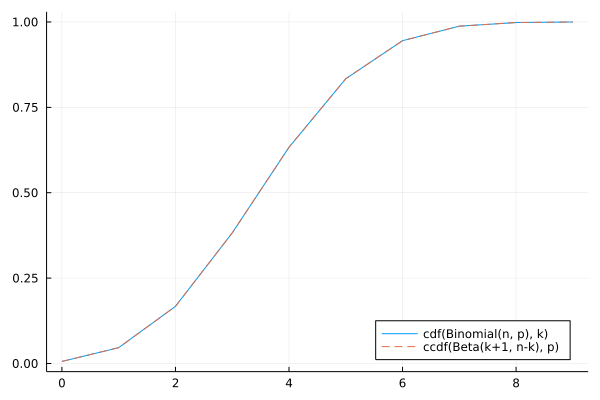

In [11]:
n, p = 10, 0.4
@show [cdf(Binomial(n, p), k) for k in 0:n-1] .== [ccdf(Beta(k+1, n-k), p) for k in 0:n-1]
@show [ccdf(Binomial(n, p), k-1) for k in 1:n] .== [cdf(Beta(k, n-k+1), p) for k in 1:n]

plot(; legend=:bottomright)
plot!(0:n-1, [cdf(Binomial(n, p), k) for k in 0:n-1]; label="cdf(Binomial(n, p), k)")
plot!(0:n-1, [ccdf(Beta(k+1, n-k), p) for k in 0:n-1]; label="ccdf(Beta(k+1, n-k), p)", ls=:dash)

## 第一種の過誤の確率の比較

In [12]:
function sim_pval_median(; dist = Gamma(2, 3), n = 40, L = 10^5)
    a = median(dist)
    pval_bst = Vector{Float64}(undef, L)
    pval_bin = Vector{Float64}(undef, L)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        pval_bst[i] = pval_median_bootstrap(X, a)
        pval_bin[i] = pval_median_binomial(X, a)
    end
    pval_bst, pval_bin
end

function plot_probtype1error(; dist = Gamma(2, 3), n = 40, L = 10^5)
    pval_bst, pval_bin = sim_pval_median(; dist, n, L)
    ecdf_bst = ecdf(pval_bst)
    ecdf_bin = ecdf(pval_bin)
    
    α = range(0, 1, 401)
    P1 = plot(; legend=:bottomright)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!([0, 1], [0, 1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")

    α = range(0, 0.1, 401)
    P2 = plot(; legend=:bottomright)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")
    
    plot(P1, P2; size=(800, 400), leftmargin=3Plots.mm, bottommargin=3Plots.mm)
end

plot_probtype1error (generic function with 1 method)

第一種の過誤の確率は母集団分布によらない.

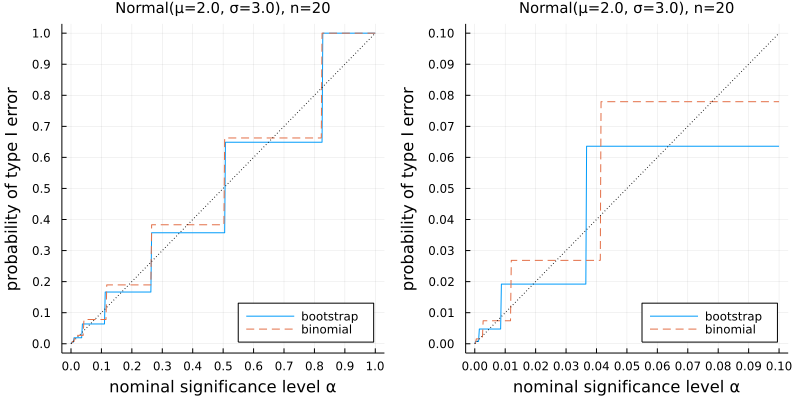

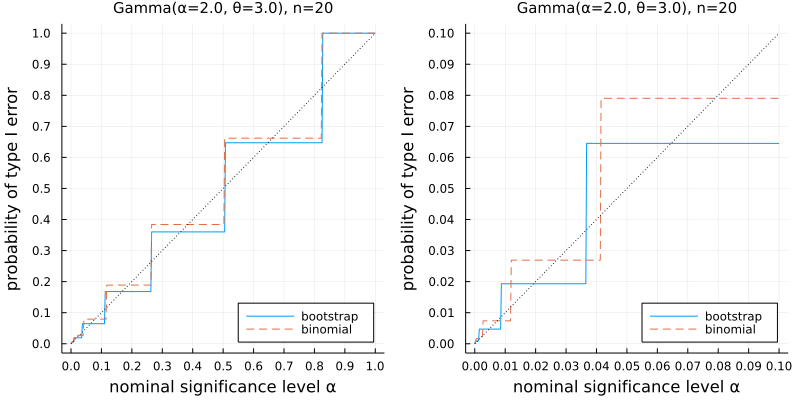

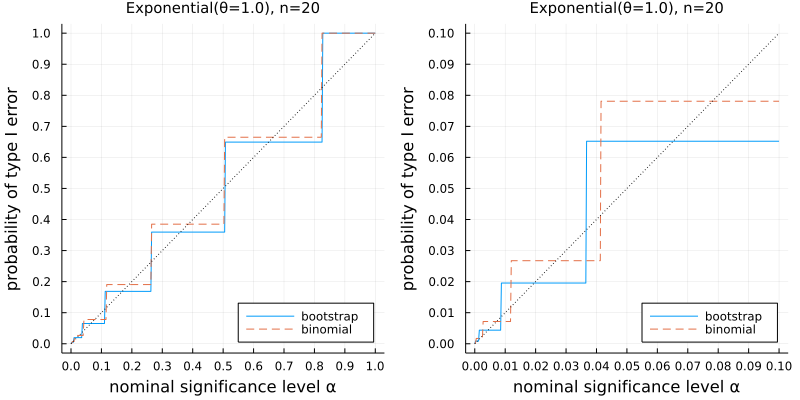

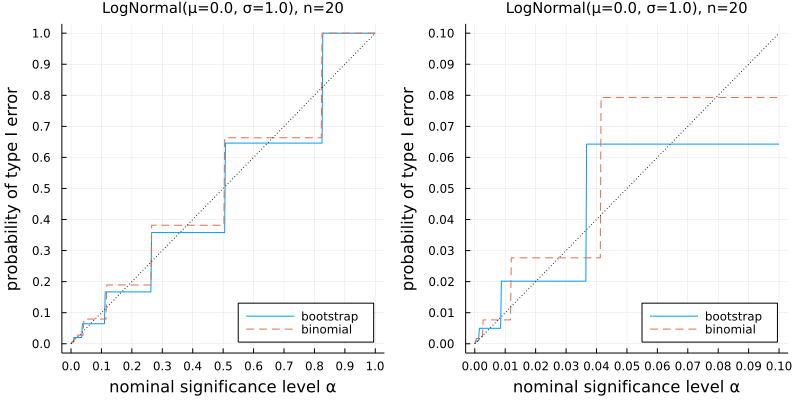

In [13]:
for dist in (Normal(2, 3), Gamma(2, 3), Exponential(), LogNormal())
    plot_probtype1error(; dist, n = 20) |> display
    println(); flush(stdout)
end

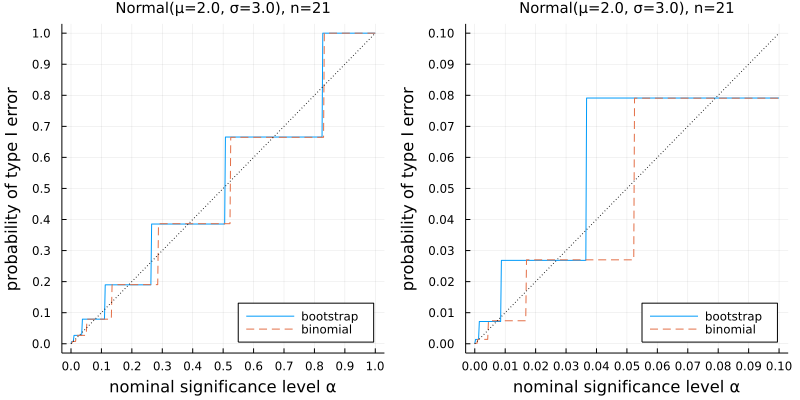

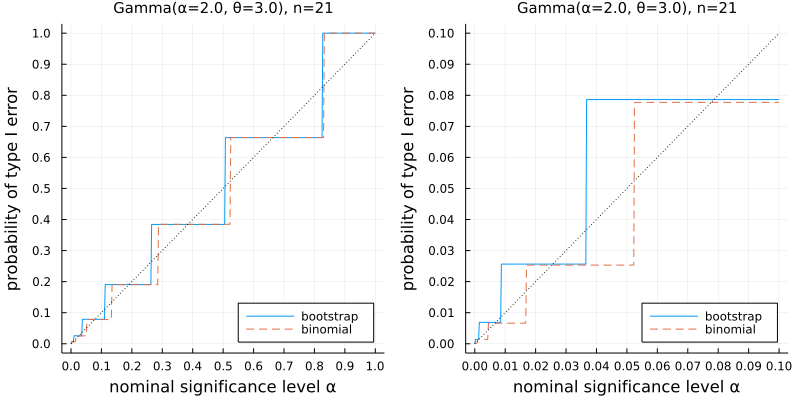

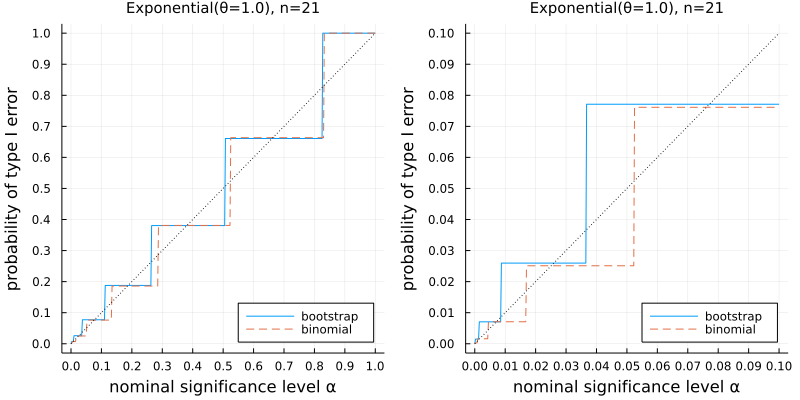

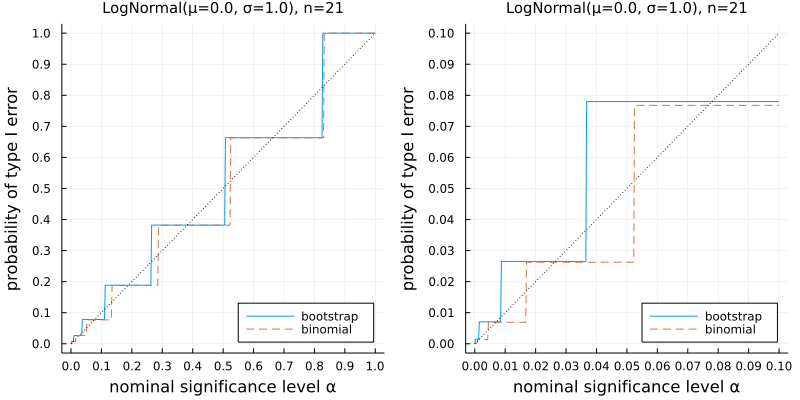

In [14]:
for dist in (Normal(2, 3), Gamma(2, 3), Exponential(), LogNormal())
    plot_probtype1error(; dist, n = 21) |> display
    println(); flush(stdout)
end

第一種の過誤の確率は名目有意水準に近い方がよい. この点に関して2つの方法の優劣は付け難い.

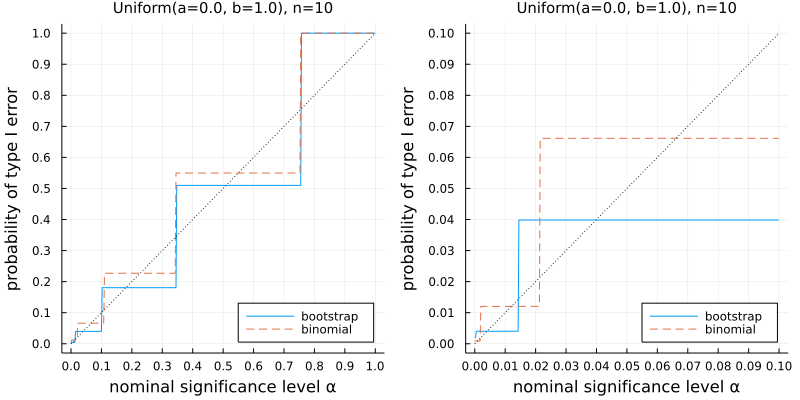

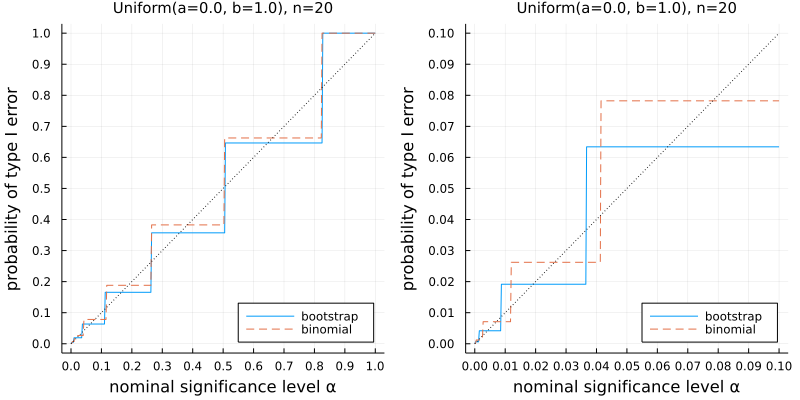

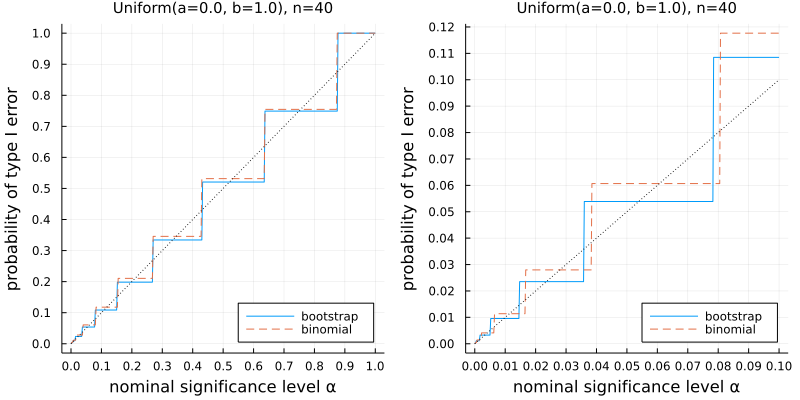

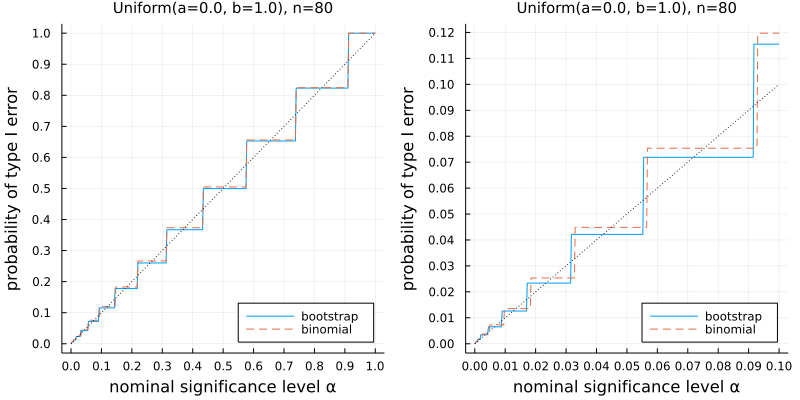

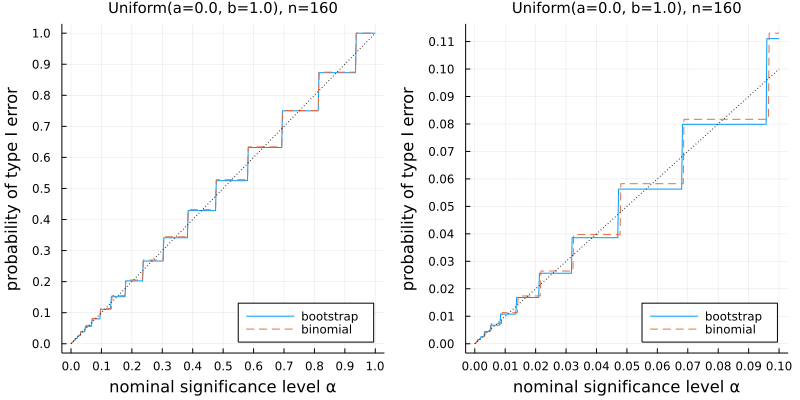

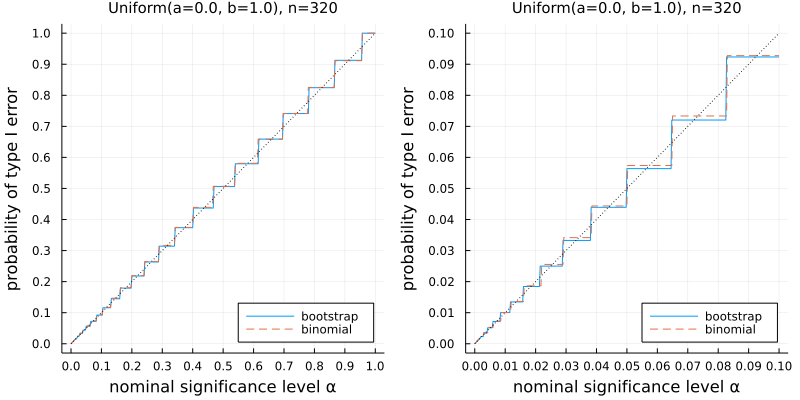

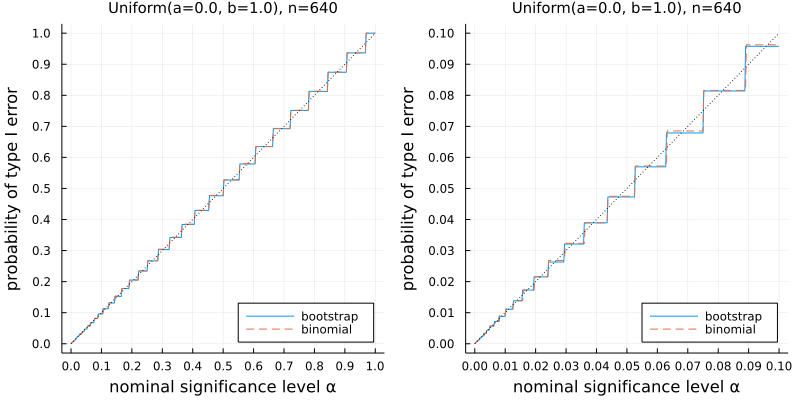

In [15]:
dist = Uniform()
for n in (10, 20, 40, 80, 160, 320, 640)
    plot_probtype1error(; dist, n) |> display
    println(); flush(stdout)
end

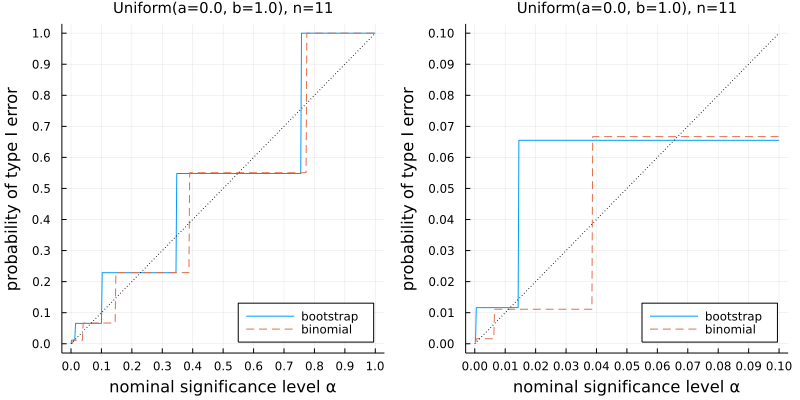

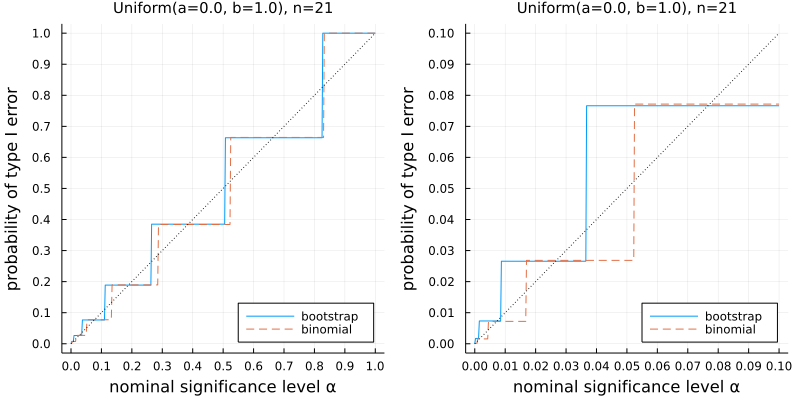

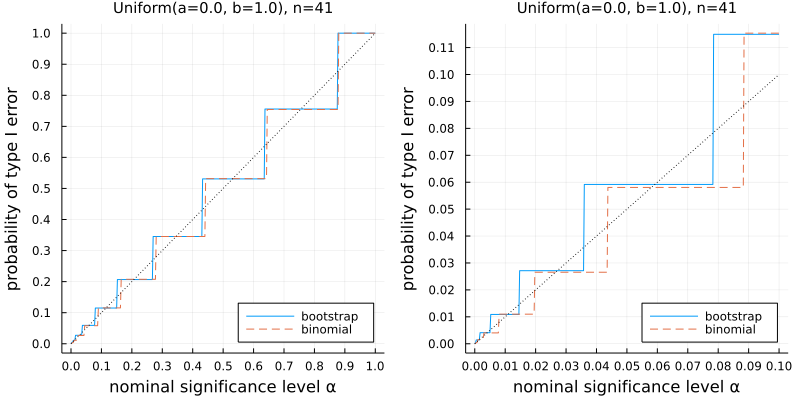

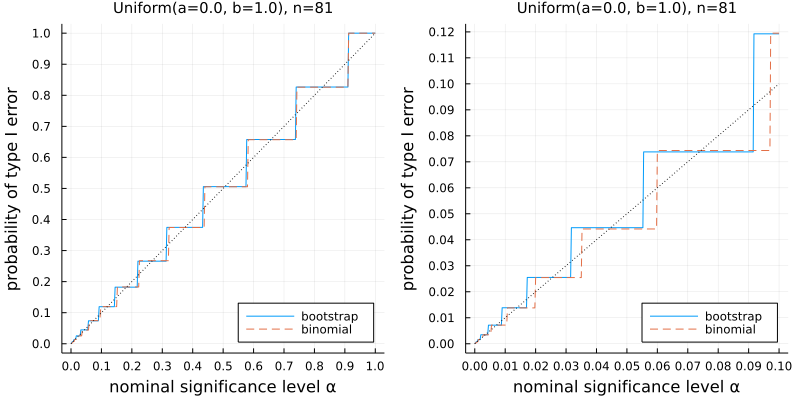

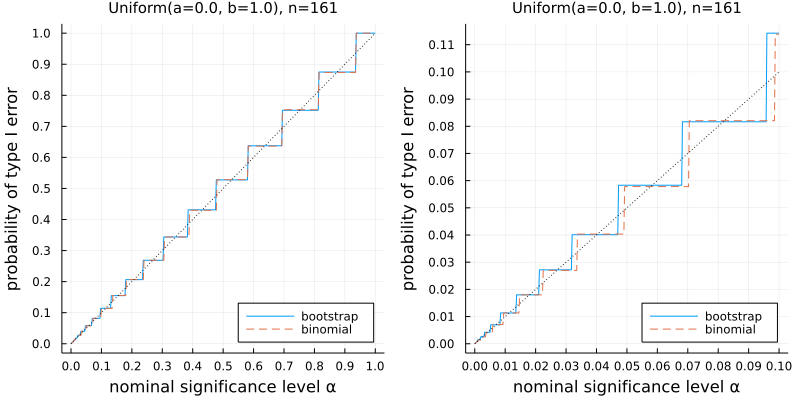

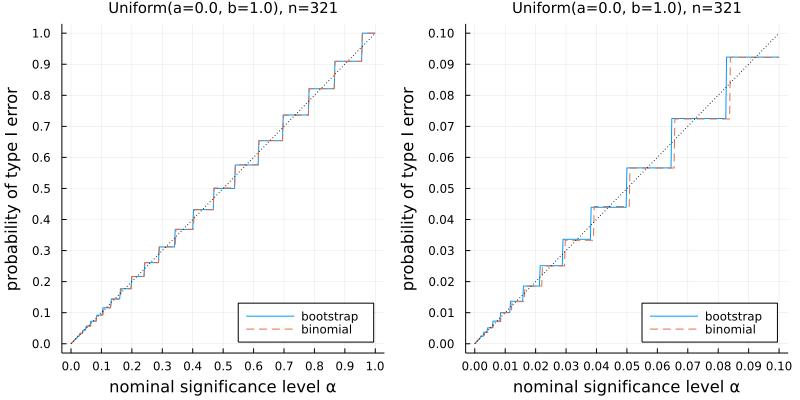

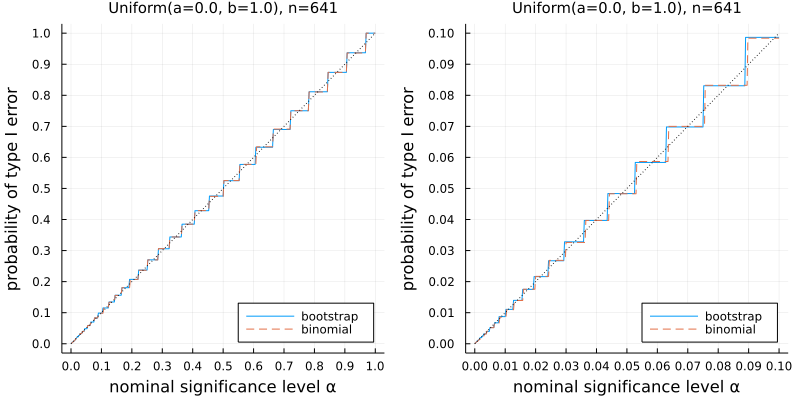

In [16]:
dist = Uniform()
for n in (10, 20, 40, 80, 160, 320, 640)
    n += 1
    plot_probtype1error(; dist, n) |> display
    println(); flush(stdout)
end

## 2つのP値の平均

In [17]:
pval_median_averaged(X, a) = (pval_median_bootstrap(X, a) + pval_median_binomial(X, a)) / 2

function sim_pval_median3(; dist = Gamma(2, 3), n = 40, L = 10^5)
    a = median(dist)
    pval_bst = Vector{Float64}(undef, L)
    pval_bin = Vector{Float64}(undef, L)
    pval_ave = Vector{Float64}(undef, L)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        pval_bst[i] = pval_median_bootstrap(X, a)
        pval_bin[i] = pval_median_binomial(X, a)
        pval_ave[i] = (pval_bst[i] + pval_bin[i])/2
    end
    pval_bst, pval_bin, pval_ave
end

function plot_probtype1error3(; dist = Gamma(2, 3), n = 40, L = 10^5)
    pval_bst, pval_bin, pval_ave = sim_pval_median3(; dist, n, L)
    ecdf_bst = ecdf(pval_bst)
    ecdf_bin = ecdf(pval_bin)
    ecdf_ave = ecdf(pval_ave)
    
    α = range(0, 1, 401)
    P1 = plot(; legend=:topleft)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!(α, α -> ecdf_ave(α); label="averaged P-value", ls=:dot, lw=2)
    plot!([0, 1], [0, 1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")

    α = range(0, 0.1, 401)
    P2 = plot(; legend=:topleft)
    plot!(α, α -> ecdf_bst(α); label="bootstrap")
    plot!(α, α -> ecdf_bin(α); label="binomial", ls=:dash)
    plot!(α, α -> ecdf_ave(α); label="averaged P-value", ls=:dot, lw=2)
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    title!("$(name(dist)), n=$n")
    plot!(; xlabel="nominal significance level α", ylabel = "probability of type I error")
    
    plot(P1, P2; size=(800, 400), leftmargin=3Plots.mm, bottommargin=3Plots.mm)
end

plot_probtype1error3 (generic function with 1 method)

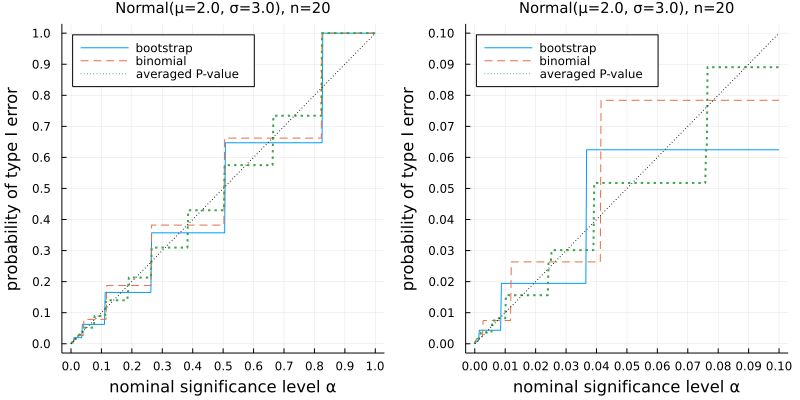

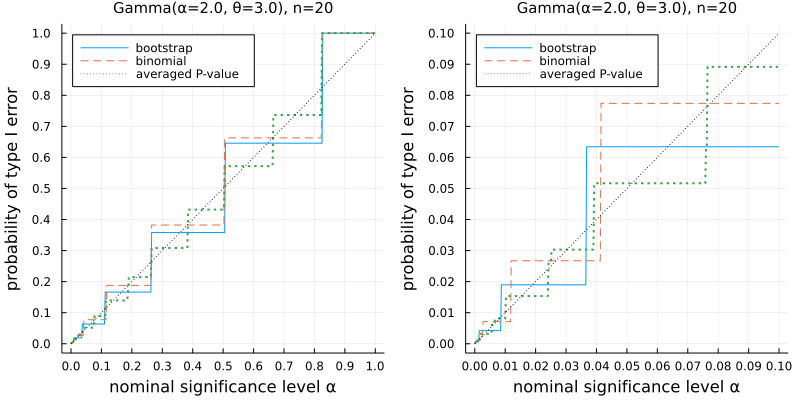

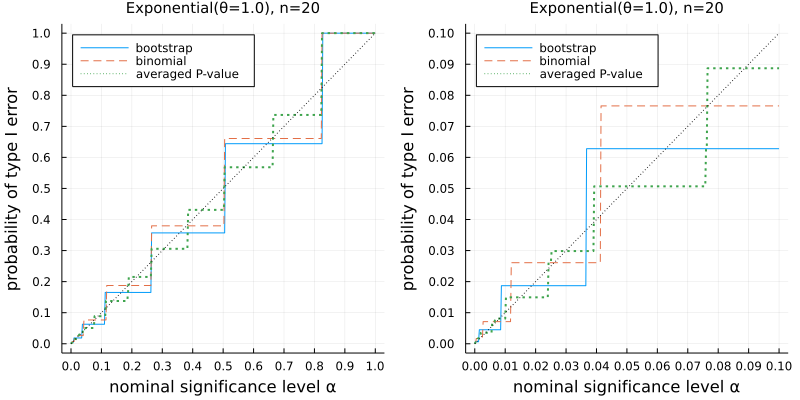

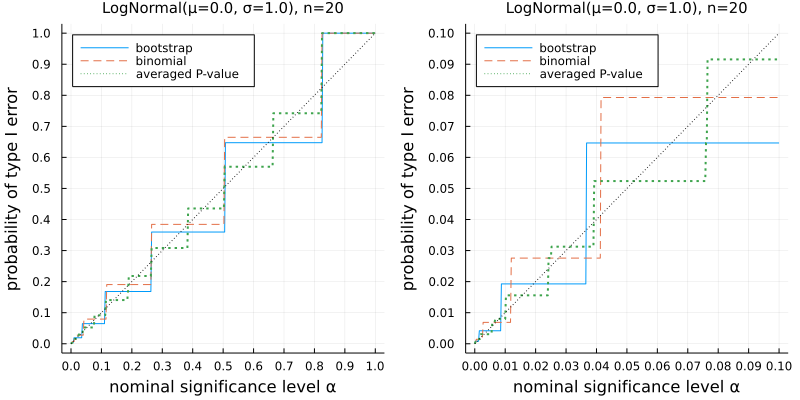

In [18]:
for dist in (Normal(2, 3), Gamma(2, 3), Exponential(), LogNormal())
    plot_probtype1error3(; dist, n = 20) |> display
    println(); flush(stdout)
end

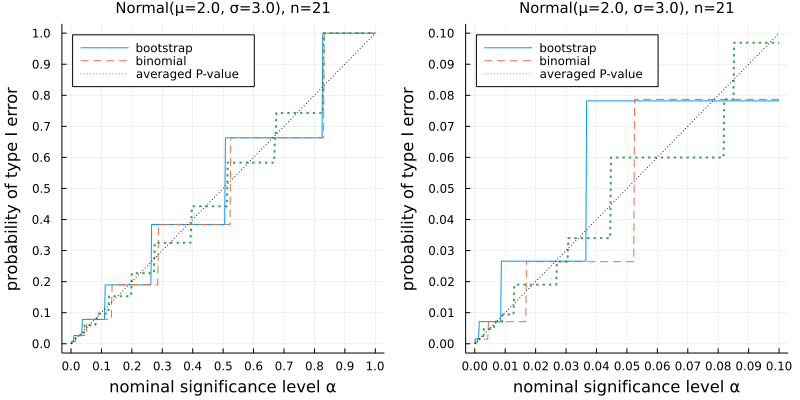

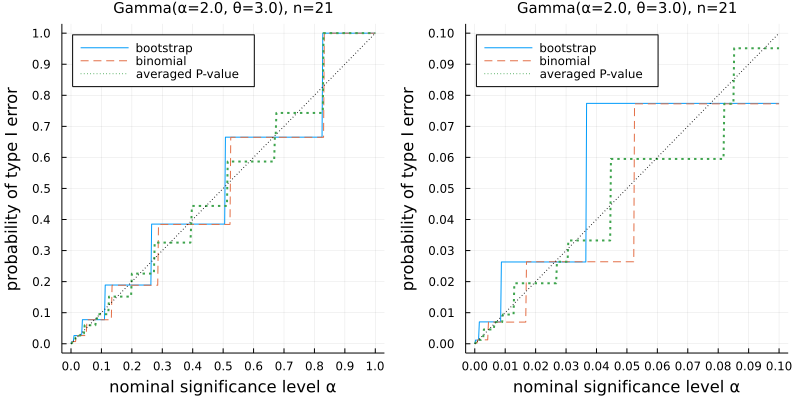

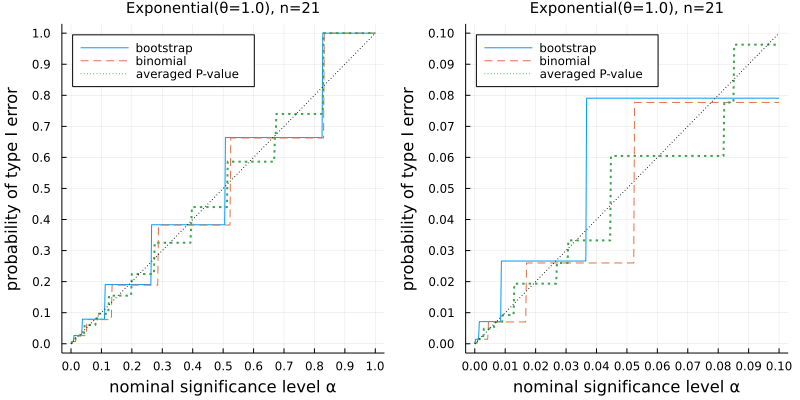

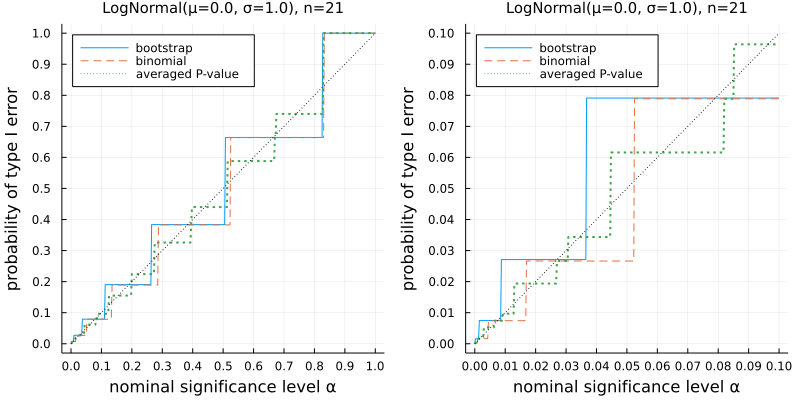

In [19]:
for dist in (Normal(2, 3), Gamma(2, 3), Exponential(), LogNormal())
    plot_probtype1error3(; dist, n = 21) |> display
    println(); flush(stdout)
end

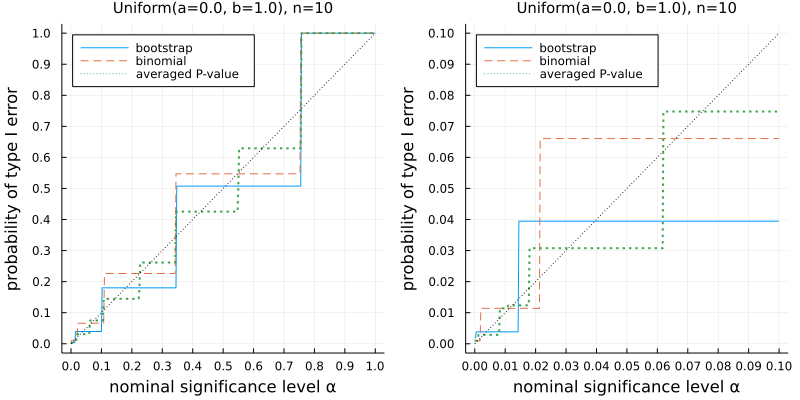

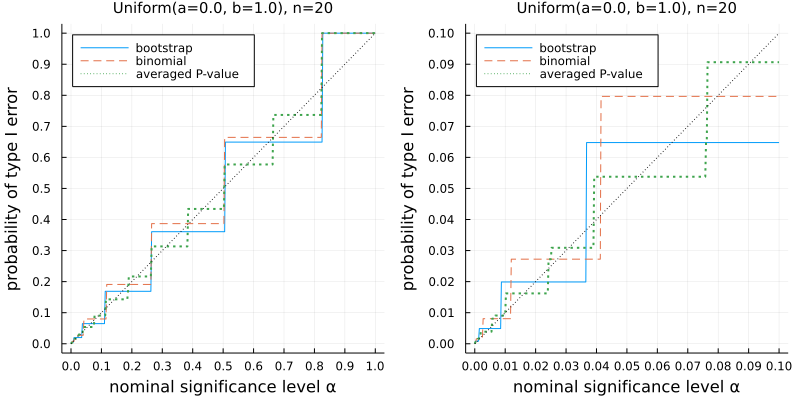

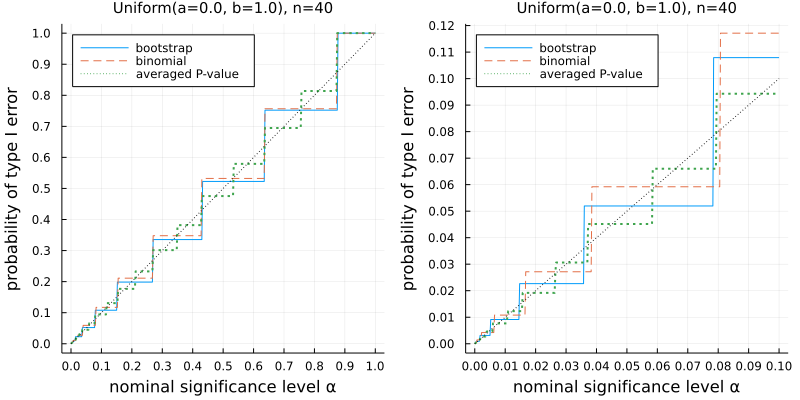

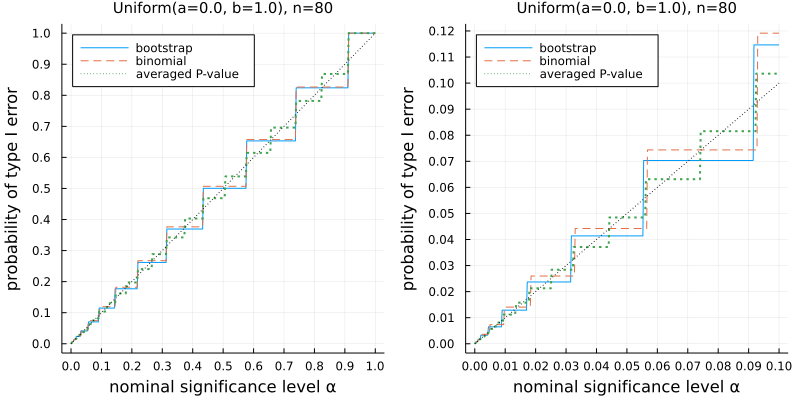

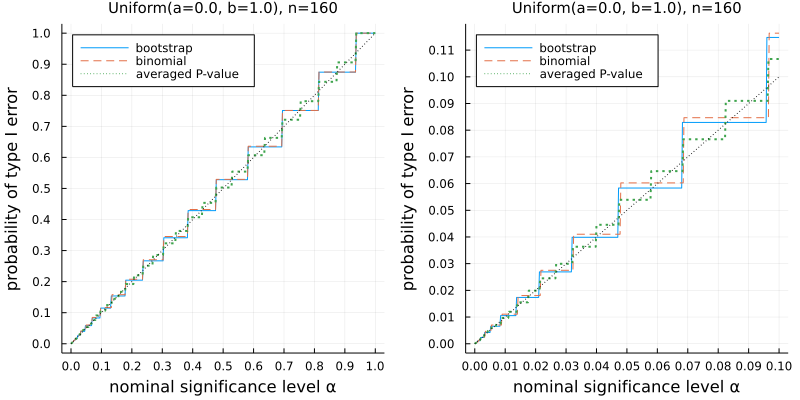

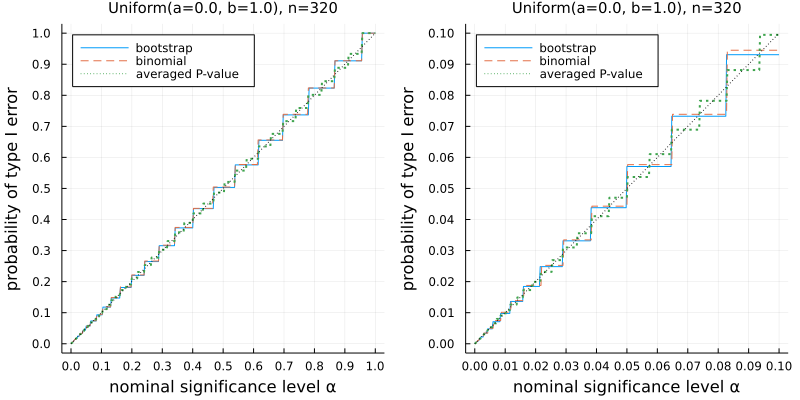

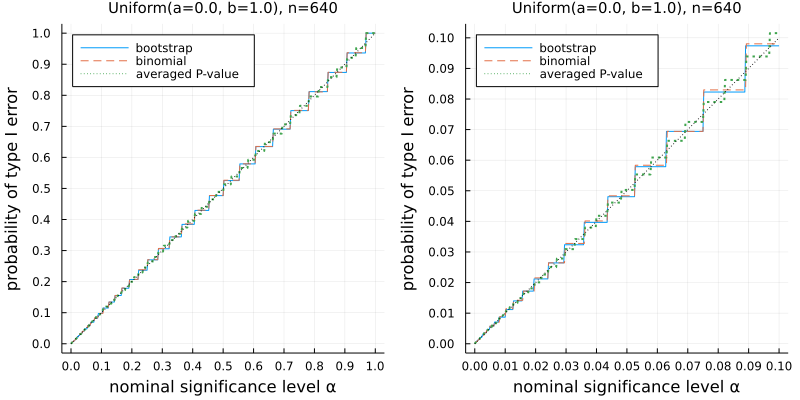

In [20]:
dist = Uniform()
for n in (10, 20, 40, 80, 160, 320, 640)
    plot_probtype1error3(; dist, n) |> display
    println(); flush(stdout)
end

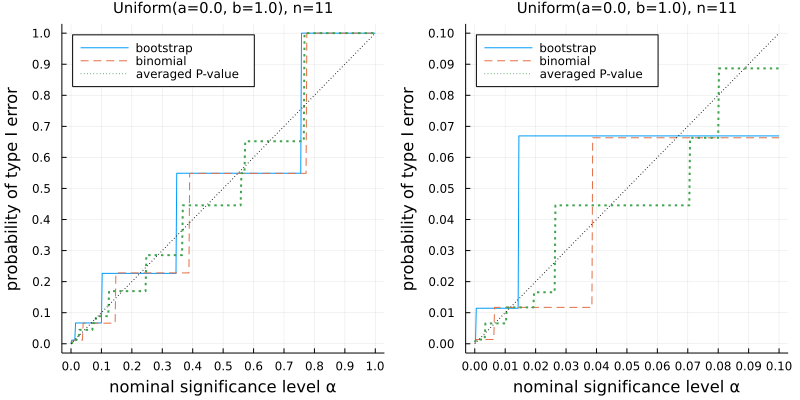

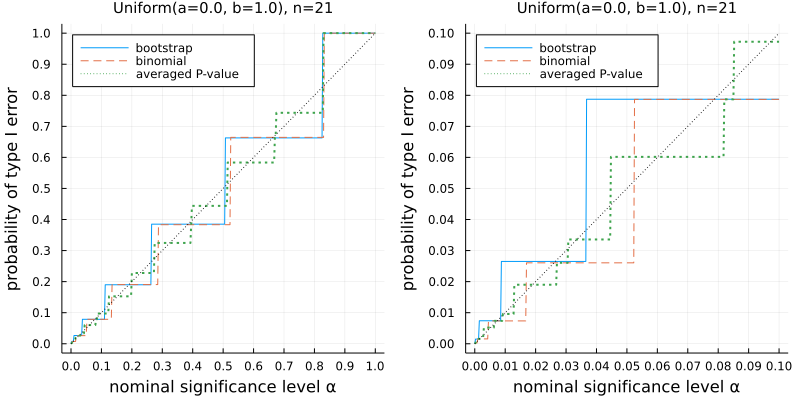

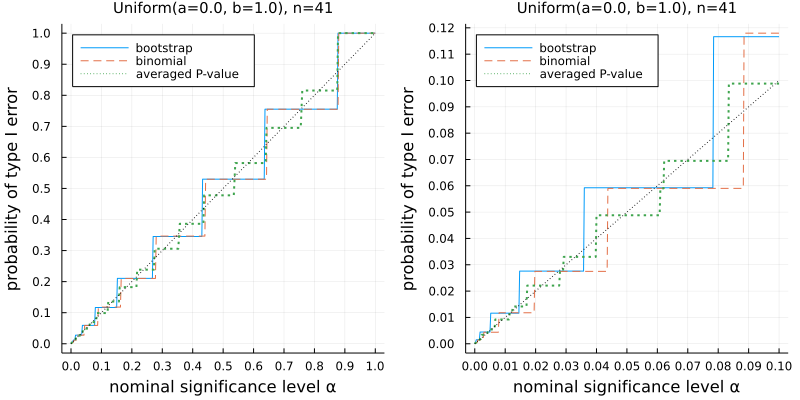

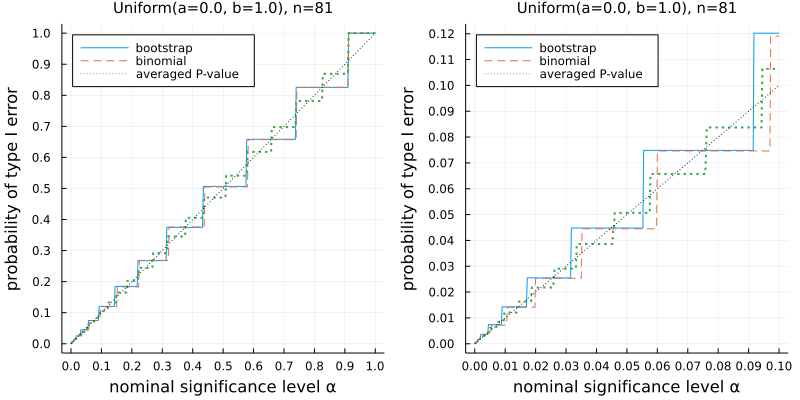

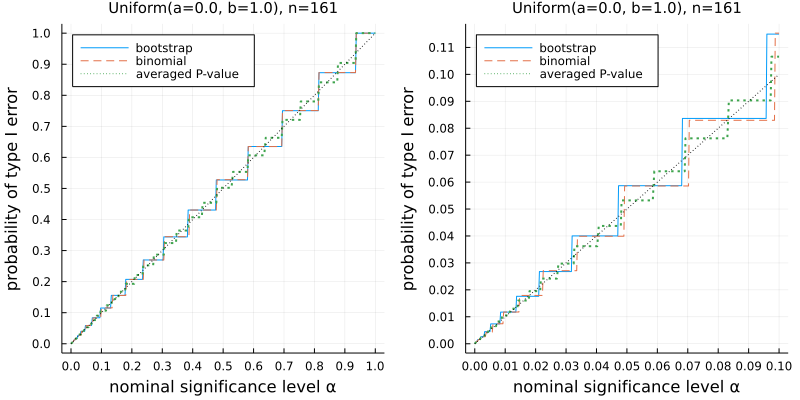

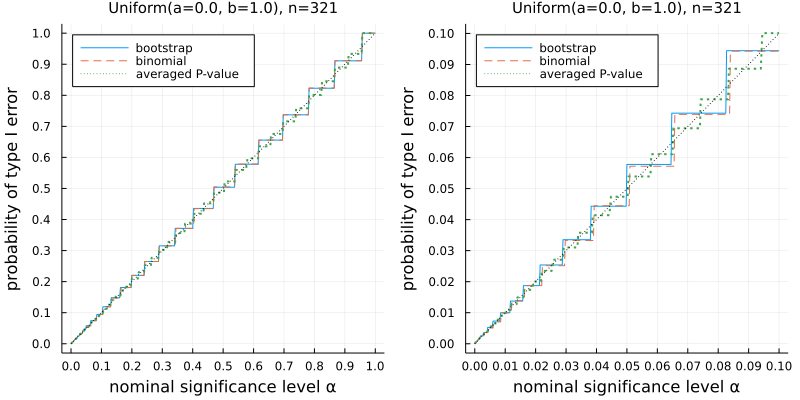

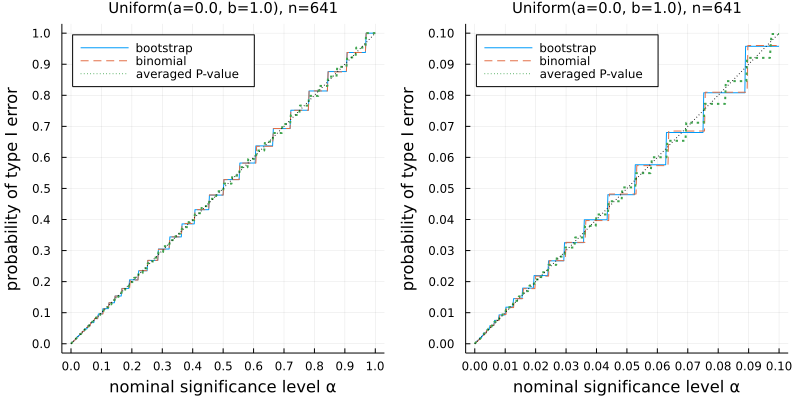

In [21]:
dist = Uniform()
for n in (10, 20, 40, 80, 160, 320, 640)
    n += 1
    plot_probtype1error3(; dist, n) |> display
    println(); flush(stdout)
end

## ヒストグラムの中央値の信頼区間

### ヒストグラムデータ

H = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -0.5:1.0:25.5
weights: [1, 5, 2, 4, 4, 4, 4, 3, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0]
closed: left
isdensity: false
H.weights = [1, 5, 2, 4, 4, 4, 4, 3, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0]


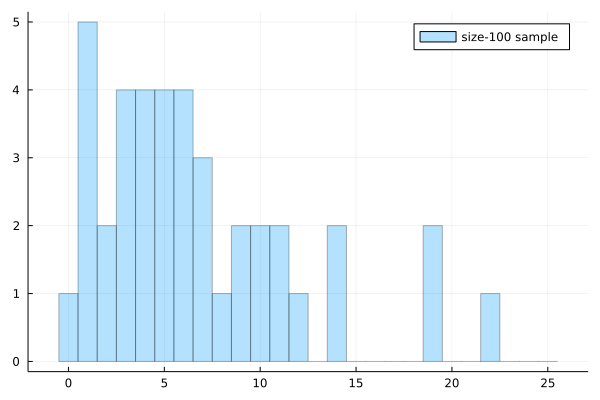

In [22]:
Random.seed!(3734649)

dist, n = Gamma(2, 3), 40
X = rand(dist, n)
bin = -0.5:25.5
H = fit(Histogram, X, bin)
@show H
@show H.weights
plot(H; alpha=0.3, label="size-100 sample")

### ヒストグラムから作られる分布

ヒストグラムから各ビンごとに一様分布に従う確率分布を作ることができる.

In [23]:
function histogramdist(h::Histogram)
    e = h.edges[1]
    w = h.weights
    u = [Uniform(e[i], e[i+1]) for i in eachindex(e)[1:end-1]]
    p = w/sum(w)
    MixtureModel(u, p)
end

histogramdist (generic function with 1 method)

Hdist = MixtureModel{Uniform{Float64}}(K = 26)
components[1] (prior = 0.0250): Uniform{Float64}(a=-0.5, b=0.5)
components[2] (prior = 0.1250): Uniform{Float64}(a=0.5, b=1.5)
components[3] (prior = 0.0500): Uniform{Float64}(a=1.5, b=2.5)
components[4] (prior = 0.1000): Uniform{Float64}(a=2.5, b=3.5)
components[5] (prior = 0.1000): Uniform{Float64}(a=3.5, b=4.5)
components[6] (prior = 0.1000): Uniform{Float64}(a=4.5, b=5.5)
components[7] (prior = 0.1000): Uniform{Float64}(a=5.5, b=6.5)
components[8] (prior = 0.0750): Uniform{Float64}(a=6.5, b=7.5)
The rest are omitted ...



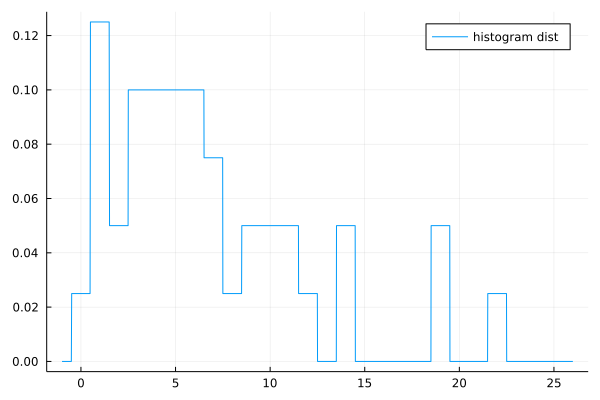

In [24]:
Hdist = histogramdist(H)
@show Hdist
plot(x -> pdf(Hdist, x), -1, 26; label="histogram dist")

ヒストグラムから作られた確率分布 $\on{Hdist}$ から平均や分散や中央値などを計算できる.

In [25]:
@show mean(Hdist)
@show var(Hdist)
@show median(Hdist)
@show quantile.(Hdist, (0.25, 0.50, 0.75));

mean(Hdist) = 6.750000000000001
var(Hdist) = 27.370833333333337
median(Hdist) = 5.499999999989996
quantile.(Hdist, (0.25, 0.5, 0.75)) = (3.0000000000045475, 5.499999999989996, 9.49999999999909)


### ブートストラップ法

In [26]:
function ci_median_bootstrap(H::Histogram; α = 0.05)
    Hdist = histogramdist(H)
    beta = beta_median(sum(H.weights))
    L = quantile(Hdist, quantile(beta, α/2))
    U = quantile(Hdist, quantile(beta, 1 - α/2))
    L, U
end

function cdf_median_bootstrap(H::Histogram, a)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    beta = beta_median(n)
    cdf(beta, cdf(Hdist, a))
end

cdf_median_bootstrap (generic function with 2 methods)

In [27]:
ci_median_bootstrap(H)

(4.013423938176769, 7.148768082424883)

`pval_ian_bootstrap` メソッドは `cdf_median_bootstrap` メソッドが実装されれば自動的に使えるようになる.

In [28]:
pval_median_bootstrap(H, 3.8)

0.023938256947349846

### 二項分布に帰着

$n$ が奇数の場合には $n$ を1増やしておかないとブートストラップ法とのずれが大きくなる.

In [29]:
function ci_median_binomial_old(H::Histogram; α = 0.05)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    bin = bin_median(n)
    L = quantile(Hdist, quantile(bin, α/2)/n)
    U = quantile(Hdist, quantile(bin, 1-α/2)/n)
    L, U
end

function ci_median_binomial(H::Histogram; α = 0.05)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    bin = bin_median(n)
    n += isodd(n)
    L = quantile(Hdist, quantile(bin, α/2)/n)
    U = quantile(Hdist, quantile(bin, 1-α/2)/n)
    L, U
end

function pval_median_binomial_old(H::Histogram, a)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    bin = bin_median(n)
    c = cdf(Hdist, a)
    min(1, 2cdf(bin, n*c), 2ccdf(bin, n*c))
end

function pval_median_binomial(H::Histogram, a)
    Hdist = histogramdist(H)
    n = sum(H.weights)
    bin = bin_median(n)
    n += isodd(n)
    c = cdf(Hdist, a)
    min(1, 2cdf(bin, n*c), 2ccdf(bin, n*c))
end

pval_median_binomial (generic function with 2 methods)

In [30]:
sum(H.weights)

40

In [31]:
ci_median_binomial(H)

(3.9999999999987272, 7.166666666672789)

In [32]:
pval_median_binomial(H, 3.8)

0.03847730828420031

### 比較

ci_bst = ci_median_bootstrap(H; α = 0.05) = (4.013423938176769, 7.148768082424883)
ci_bin = ci_median_binomial(H; α = 0.05) = (3.9999999999987272, 7.166666666672789)


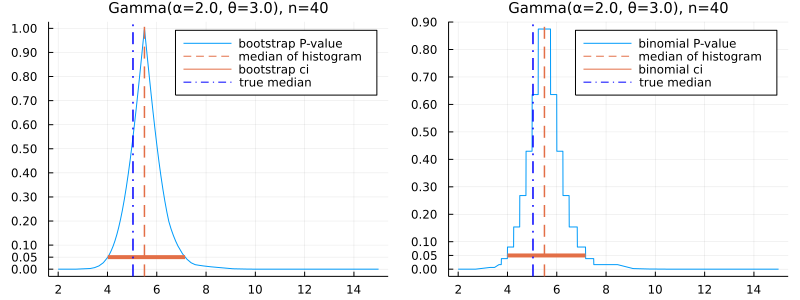

In [33]:
# 信頼区間の計算
@show ci_bst = ci_median_bootstrap(H; α = 0.05)
@show ci_bin = ci_median_binomial(H; α = 0.05)

# プロット
P2 = plot(x -> pval_median_bootstrap(H, x), 2, 15; label="bootstrap P-value")
vline!([median(Hdist)]; label="median of histogram", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bst), fill(0.05, 2); label="bootstrap ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

P3 = plot(x -> pval_median_binomial(H, x), 2, 15; label="binomial P-value")
vline!([median(Hdist)]; label="median of histogram", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), fill(0.05, 2); label="binomial ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(P2, P3; size=(800, 300))

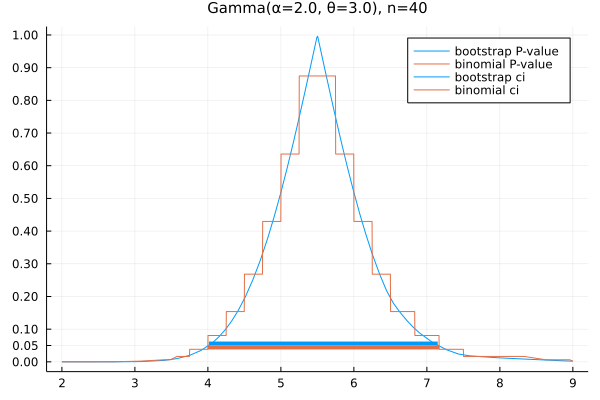

In [34]:
plot(x -> pval_median_bootstrap(H, x), 2, 9; label="bootstrap P-value")
plot!(x -> pval_median_binomial(H, x), 2, 9; label="binomial P-value")
plot!(collect(ci_bst), fill(0.056, 2); label="bootstrap ci", lw=4, c=1)
plot!(collect(ci_bin), fill(0.044, 2); label="binomial ci", lw=4, c=2)
plot!(; xtick=-1:21, ytick=[0:0.05:0.1; 0.2:0.1:1])
title!("$(name(dist)), n=$n")

H = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -0.5:1.0:25.5
weights: [1, 5, 2, 5, 4, 4, 4, 3, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0]
closed: left
isdensity: false
H.weights = [1, 5, 2, 5, 4, 4, 4, 3, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0]


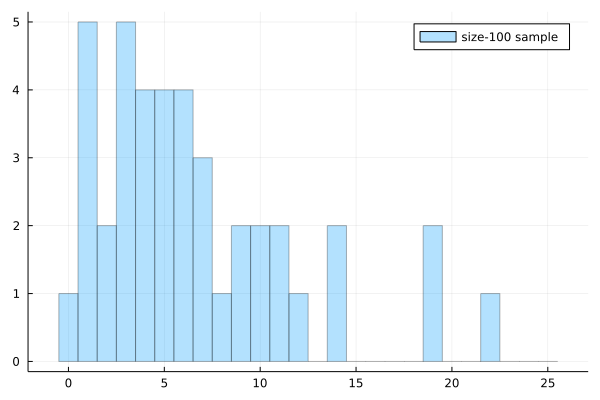

In [35]:
Random.seed!(3734649)

dist, n = Gamma(2, 3), 41
X = rand(dist, n)
bin = -0.5:25.5
H = fit(Histogram, X, bin)
@show H
@show H.weights
plot(H; alpha=0.3, label="size-100 sample")

ci_bst = ci_median_bootstrap(H; α = 0.05) = (3.8512595366372837, 7.0316539511678435)
ci_bin = ci_median_binomial(H; α = 0.05) = (3.910714285710778, 6.9523809523719)


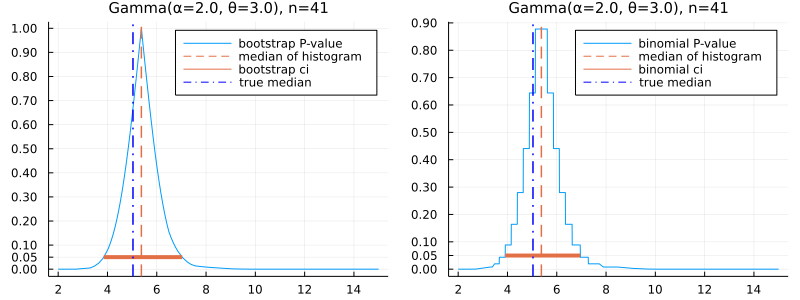

In [36]:
Hdist = histogramdist(H)

# 信頼区間の計算
@show ci_bst = ci_median_bootstrap(H; α = 0.05)
@show ci_bin = ci_median_binomial(H; α = 0.05)

# プロット
P2 = plot(x -> pval_median_bootstrap(H, x), 2, 15; label="bootstrap P-value")
vline!([median(Hdist)]; label="median of histogram", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bst), fill(0.05, 2); label="bootstrap ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

P3 = plot(x -> pval_median_binomial(H, x), 2, 15; label="binomial P-value")
vline!([median(Hdist)]; label="median of histogram", lw=1.5, c=2, ls=:dash)
plot!(collect(ci_bin), fill(0.05, 2); label="binomial ci", lw=4, c=2)
vline!([median(dist)]; label="true median", lw=1.5, c=:blue, ls=:dashdot)
title!("$(name(dist)), n=$n")
plot!(; ytick=[0:0.05:0.1; 0.2:0.1:1])

plot(P2, P3; size=(800, 300))

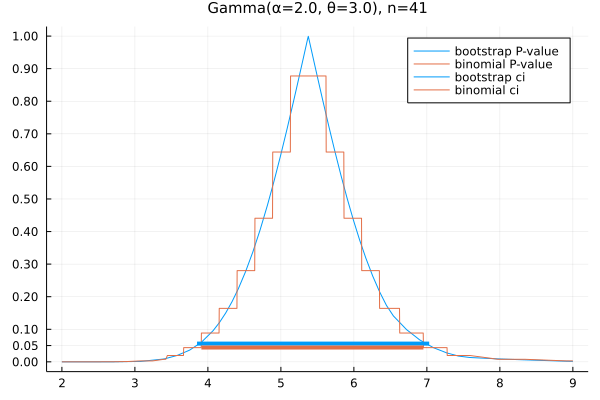

In [37]:
plot(x -> pval_median_bootstrap(H, x), 2, 9; label="bootstrap P-value")
plot!(x -> pval_median_binomial(H, x), 2, 9; label="binomial P-value")
plot!(collect(ci_bst), fill(0.056, 2); label="bootstrap ci", lw=4, c=1)
plot!(collect(ci_bin), fill(0.044, 2); label="binomial ci", lw=4, c=2)
plot!(; xtick=-1:21, ytick=[0:0.05:0.1; 0.2:0.1:1])
title!("$(name(dist)), n=$n")